# Одномерная линейная регрессия. 

Простая линейная регрессия моделирует связь между величиной одной переменной и величиной второй. Например, по мере увеличения $X$ увеличивается и $Y$ или же наоборот уменьшается. Рассмотрим на примере предсказания прибыли от продовольственных перевозок. Допустим, есть данные прибыли от перевозок еды в рестораны некоторых городов с известной численностью населения.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
headers = ['population', 'profit']
df = pd.read_csv('ex1data1.csv', names=headers)

In [3]:
df.head()

,population,profit
0,6.1101,17.5920
1,5.5277,9.1302
2,8.5186,13.6620
3,7.0032,11.8540
4,5.8598,6.8233


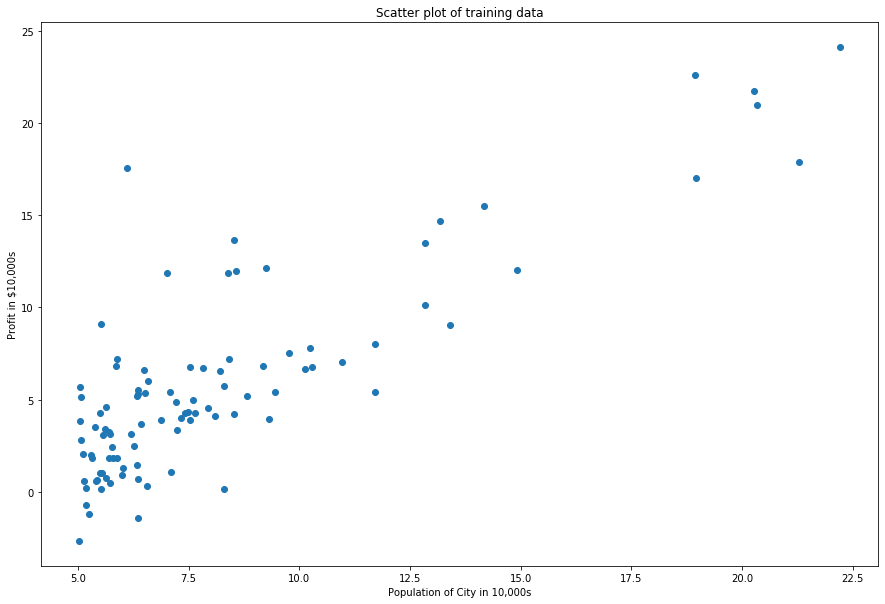

In [4]:
plt.figure(figsize=(15, 10))
plt.scatter(df.population, df.profit)
plt.ylabel('Profit in $10,000s')
plt.xlabel('Population of City in 10,000s')
plt.title('Scatter plot of training data')
plt.show()

## Корреляция

Из графика видно, что с увеличением численности населения увеличивается и прибыль. Корреляция — ещё один способ измерить, каким образом связаны две переменные.

In [5]:
df.corr()

,population,profit
population,1.000000,0.837873
profit,0.837873,1.000000


Выше представлена таблица корреляций (или корреляционная матрица). Она состоит из выборочных коэффициентов корреляции, каждый из которых измеряет степень, с какой числовые переменные связаны друг с другом в диапозоне от -1 (идеальная отрицательная корреляция) до 1 (идеальная положительная корреляция). Значение 0 свидетельствует об отсутствии корреляции. Каждый выборочный коэффициент корреляции из корреляционной матрицы вычисляется по формуле
$$ \hat r_{xy} = \dfrac{\sum\limits_{i = 1}^{n} \left( x_i - \overline{x} \right) \left( y_i - \overline{y} \right)}{n s_x s_y}, $$
где $s_x = \sqrt{\hat d_x(n)}$, $s_y = \sqrt{\hat d_y(n)}$ — стандартные отклонения, где
$$ \hat d_x(n) = \dfrac{\sum\limits_{i = 1}^{n} \left( x_i - \overline{x} \right)^2}{n}, \quad \hat d_y(n) = \dfrac{\sum\limits_{i = 1}^{n} \left( y_i - \overline{y} \right)^2}{n}, $$
называются выборочными дисперсиями, а $\overline{x} = \hat m_x(n)$, $\overline{y} = \hat m_y(n)$ — выборочные средние:
$$ \overline{x} = \dfrac{1}{n} \sum\limits_{i = 1}^{n} x_i, \quad \overline{y} = \dfrac{1}{n} \sum\limits_{i = 1}^{n} y_i. $$

In [6]:
n = df.shape[0]
x_mean = np.sum(df.population) / n
y_mean = np.sum(df.profit) / n
x_std = np.sum((df.population - x_mean) ** 2) / n
y_std = np.sum((df.profit - y_mean) ** 2) / n

r = np.sum((df.population - x_mean) * (df.profit - y_mean)) / (n * np.sqrt(x_std) * np.sqrt(y_std))

print('Correlation coefficient =', r)

Correlation coefficient = 0.8378732325263412


Таким образом мы получили значение коэффициента корреляции для прибыли продовольственных перевозок и численности населения, который в корреляционной матрице находится на побочной диагонали. Поскольку его значение ближе к единице, можно говорить о положительной корреляции этих переменных.

В отличие от корреляции, линейная регрессия позволяет квантифицировать природу этой взаимосвязи и предсказать приблизительное значение прибыли для городов с численностью населения, отличной от известных нам.

## Модель линейной регрессии

Простая линейная регрессия оценивает, насколько именно изменится $Y$, когда $X$ изменится на определенную величину. Для коэффициента корреляции переменные взаимозаменяемы, о чем говорит симметричность корреляционной матрицы. В случае же с регрессией мы пытаемся предсказать переменную $Y$ из переменной $X$, используя линейное соотношение
$$ Y = \theta_0 + \theta_1 X, $$
где $\theta_0$ называется _пересечением_, а $\theta_1$ — _наклоном_ для $X$. Переменная $Y$ называется _откликом_, _целью_ или _зависимой_ переменной, а $X$ называется _предиктором_, _вектором признаков_ или _независимой_ переменной.

Поскольку уравнение регрессии задано линейным соотношением, то и в результате мы получим прямую. Как правило она не проходит точно через все имеющиеся данные, поэтому уравнение регрессии должно включать в себя заданный в явной форме остаточный член $e$:
$$ Y = \theta_0 + \theta_1 X + e.$$
_Подогнанные_, или _предсказанные_, значения задаются следующей формулой:
$$ \hat{Y} = \hat{\theta_0} + \hat{\theta_1} X.$$
Форма записи коэффициентов регрессии (с шляпой) говорит о том, что они оценочные (расчетные) в отличие от точных.

Мы вычисляем остатки $\hat{e_i}$ путем вычитания предсказанных значений из исходных данных:
$$ \hat{e_i} = Y_i - \hat{Y_i}. $$
То есть, остатки — длина вертикальных расстояний от данных до прямой регрессии.

## Метод наименьших квадратов

Прямая регрессии является оценкой, которая минимизирует сумму квадратических значений остатков, также именуемых _остаточной суммой квадратов_ (RSS):
$$ RSS = \sum\limits_{i = 1}^{n} \left( Y_i - \hat{Y_i} \right)^2 = \sum\limits_{i = 1}^{n} \left( Y_i - \hat{\theta_0} - \hat{\theta_1} X_i \right)^2. $$
Оценки $\hat{\theta_0}$ и $\hat{\theta_1}$ — это значения, которые минимизируют $RSS$.

Для удобства сумму в $RSS$ часто домножают константой $\dfrac{1}{2n}$:
$$ RSS = \dfrac{1}{2n} \sum\limits_{i = 1}^{n} \left( Y_i - \hat{\theta_0} - \hat{\theta_1} X_i \right)^2. $$

Методом минимизации суммы квадратических остатков называется _методом наименьших квадратов_. Он основан на необходимом условии существования экстремума функции многих переменных, которое требует равенства нулю первых частных производных по переменным, по которым минимизируется функция.

То есть, должны выполняться равенства
$$ \dfrac{\partial RSS}{\partial \hat{\theta_0}} = \dfrac{1}{n} \sum\limits_{i = 1}^{n} \left( Y_i - \hat{\theta_0} - X_i \hat{\theta_1} \right) \cdot (-1) = -\dfrac{1}{n} \sum\limits_{i} Y_i + \hat{\theta_0} + \dfrac{\hat{\theta_1}}{n} \sum\limits_{i} X_i = 0, $$
$$ \dfrac{\partial RSS}{\partial \hat{\theta_1}} = \dfrac{1}{n} \sum\limits_{i = 1}^{n} \left( Y_i - \hat{\theta_0} - X_i \hat{\theta_1} \right) \cdot \left( -X_i \right) = -\dfrac{1}{n} \sum\limits_i Y_i X_i + \dfrac{\hat{\theta_0}}{n} \sum\limits_i X_i + \dfrac{\hat{\theta_1}}{n} \sum\limits_i X_i^2 = 0. $$
Откуда
$$ \hat{\theta_0} = \dfrac{1}{n} \sum\limits_i Y_i - \dfrac{\hat{\theta_0}}{n} \sum\limits_i X_i = \overline{Y} - \hat{\theta_1} \overline{X}, $$
$$ \hat{\theta_1} = \dfrac{\sum\limits_i Y_i X_i - \dfrac{1}{n}\sum\limits_i Y_i \sum\limits_i X_i}{\sum\limits_i X_i^2 - \dfrac{1}{n} \left( \sum\limits_i X_i \right)^2}. $$

Можно заметить, что
$$ \hat{\theta_1} = \dfrac{Cov(X_{(n)}, Y_{(n)})}{\hat{d}_X(n)} = \hat r_{XY} \sqrt{\dfrac{\hat d_Y}{\hat d_X}}, $$
$$ \hat{\theta_0} = \hat m_Y - \hat{\theta_1} \hat m_X, $$
где $Cov(X_{(n)}, Y_{(n)})$ — выборочная ковариация, $\hat{d}_X(n)$ — выборочная дисперсия.

По полученным уравнениям можем найти значения коэффициентов регрессии для нашего примера.

In [13]:
theta_1 = r * np.sqrt(y_std / x_std)
theta_0 = y_mean - theta_1 * x_mean

print('Coeffitients of regression:', theta_0, theta_1)

Coeffitients of regression: -3.8957808783118573 1.1930336441895943


In [15]:
# fitted values
y_hat = theta_0 + theta_1 * df.population

Посмотрим, какая ожидается прибыль от городов с населением 35000 и 70000 человек.

In [11]:
profit_35k = round((theta_0 + theta_1 * 3.5) * 10000)
profit_70k = round((theta_0 + theta_1 * 7) * 10000)

print(f'For population of 35,000 people we predict a profit of {profit_35k}$.\nFor population of 70,000 people we predict a profit of {profit_70k}$.')

For population of 35,000 people we predict a profit of 2798.0$.
For population of 70,000 people we predict a profit of 44555.0$.


На графике изображена полученная прямая линейной регрессии.

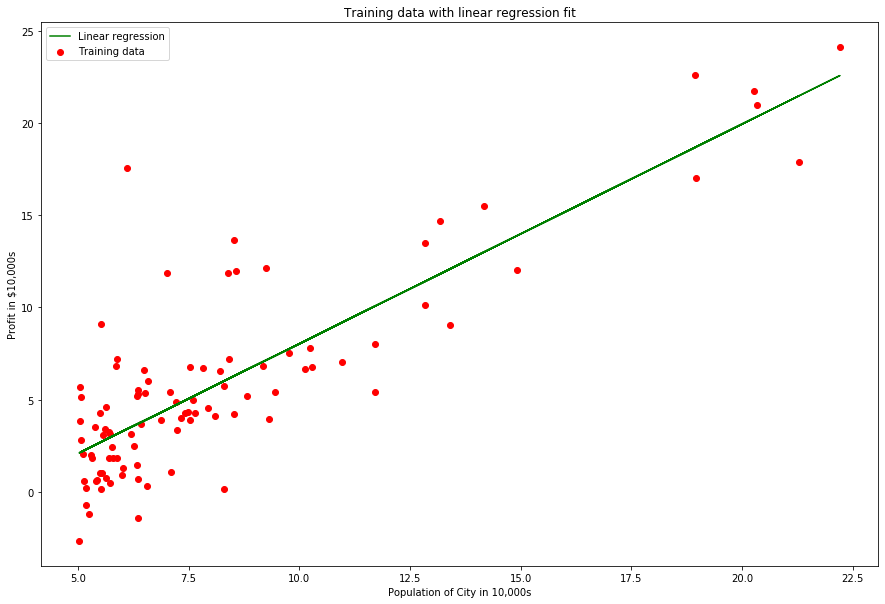

In [16]:
plt.figure(figsize=(15, 10))
plt.scatter(df.population, df.profit, color='red')
plt.plot(df.population, y_hat, color='green')
plt.ylabel('Profit in $10,000s')
plt.xlabel('Population of City in 10,000s')
plt.legend(['Linear regression', 'Training data'])
plt.title('Training data with linear regression fit')
plt.show()

# Список использованных источников

1. Материалы курса Machine Learning - Andrew Ng, Stanford University on Coursera.
2. Брюс, П. Практическая статистика для специалистов Data Science: Пер. с англ. / П. Брюс, Э Брюс. — СПб.: БХВ-Петербург, 2019. — 304 с.: ил.
3. Кибзун А. И., Горяинова Е. Р., Наумов А. В. Теория вероятностей и математическая статистика. Базовый курс с примерами и задачами: Учебник. — 3-е изд., перераб. и доп. — М.: ФИЗМАТЛИТ, 2013. — 232 с.
4. http://www.machinelearning.ru/wiki/images/f/fc/MOTP14_3.pdf